# NETWORK SCIENCE VK PROJECT

connecting some stuff

In [81]:
import requests
import time
import collections
import matplotlib.pyplot as plt
import networkx as nx
import operator
import pandas as pd
import numpy as np
import itertools
import scipy.spatial as spt
import seaborn as sns
sns.set()
%matplotlib inline

Всякие полезные функции для API

In [ ]:
# функция возвращает список друзей
def get_friends_ids(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&v=5.52' 
    # также вы можете добавить access_token в запрос, получив его через OAuth 2.0
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('error'):
        #print json_response.get('error')
        return list()
    return json_response[u'response']

In [7]:
# функция возвращает имя юзера
def find_name(id_interest):
    resp=requests.get('https://api.vk.com/method/users.get?user_ids={}&v=5.52'.format(id_interest)).json()[u'response']
    return resp[0][u'first_name'].strip()+' '+resp[0][u'last_name'].strip()

# функция пишет имя
def print_info_about(i, id_interest, G):  
    resp=requests.get('https://api.vk.com/method/users.get?user_ids={}&v=5.52'.format(id_interest)).json()[u'response']
    print(str(i)+". "+resp[0][u'first_name'].strip()+' '+resp[0][u'last_name'].strip()+' '+str(G.degree()[id_interest]))

Начинаем создавать граф

In [ ]:
graph = {}
friend_ids = get_friends_ids(11759642)  # мой id

In [ ]:
num = 1
for friend_id in friend_ids["items"]:
   # print (str(num)+". "'Processing id: ', friend_id)
    friend_friends = get_friends_ids(friend_id)
    if len(friend_friends) > 0:
        graph[friend_id] = friend_friends["items"]
    num += 1

In [ ]:
g = nx.Graph(directed=False)

In [ ]:
myfriends = list(graph.keys())
for i in myfriends:
    g.add_node(i)
    for j in graph[i]:
        if i != j and j in myfriends:
            g.add_edge(i, j)

Поскольку есть некрасивые отдельные вершины, не связанные ни с кем, я просто сразу беру максимальный подграф. 95% друзей туда входят. Но вообще это делать необязательно

In [ ]:
g = g.subgraph(max(nx.connected_component_subgraphs(g), key=len))

Запись графа

In [189]:
networkx.write_gml(g, "network.gml")

Запись графа с именами вместо ID

In [190]:
G = nx.relabel_nodes(g, find_name)

In [191]:
networkx.write_gml(G, "network1.gml")

## ЗДЕСЬ ЗАКАНЧИВАЕТСЯ РАБОТА С API И НАЧИНАЕТСЯ АНАЛИЗ

Читаем графы

In [192]:
G1 = nx.read_gml('network.gml')
G = nx.read_gml('network1.gml')

In [2]:
G1 = nx.read_gml('network.gml')
G = nx.read_gml('network1.gml')

Смотрим всякие degree

In [4]:
k = nx.degree(G)
k1 = nx.degree(G1)

Заплотим некрасивый график (Gephi круче)

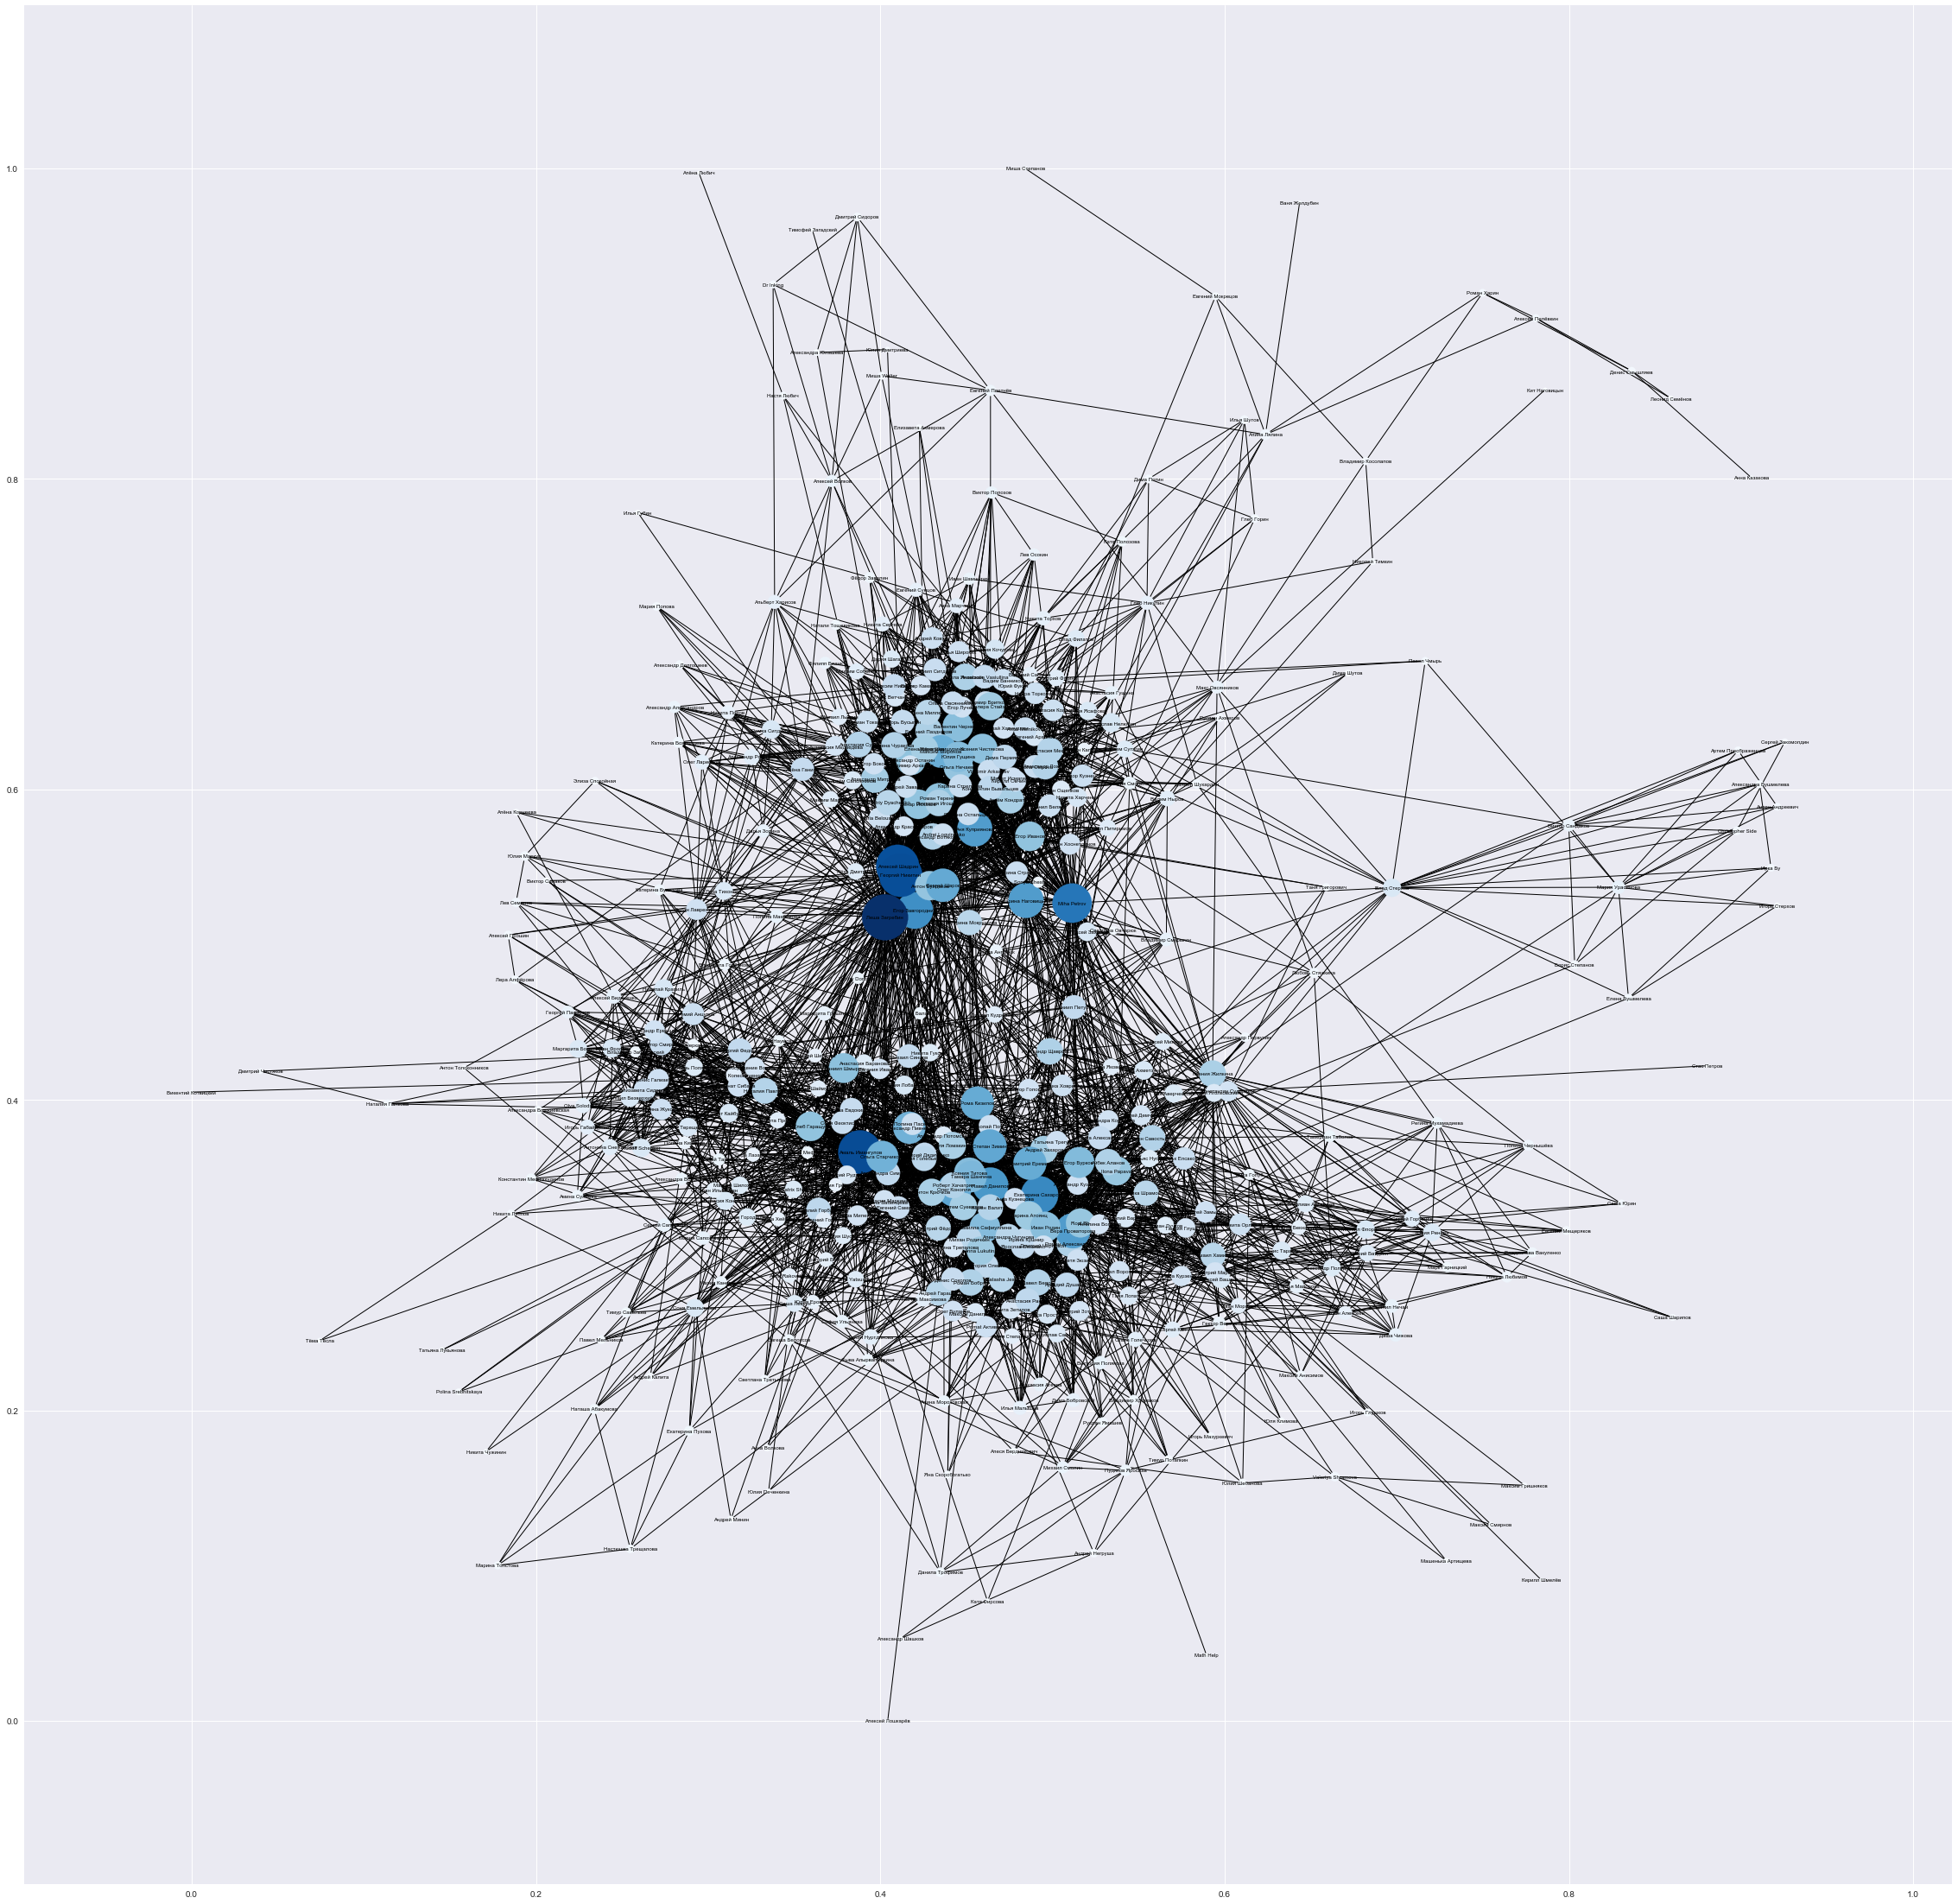

In [57]:
plt.figure(1, figsize=(40,40))
coord = nx.spring_layout(G)
nx.draw_networkx(G,
                 pos=coord,
                 nodelist=list(k.keys()),
                 node_size = [d*20 for d in list(k.values())],
                 node_color=list(k.values()),
                 font_size=6,
                 cmap=plt.cm.Blues,
                 with_labels=True
                 )

Это граф для Gephi

In [196]:
nx.write_gexf(G, "my_graph.gexf")

# ДИАМЕТР

In [156]:
diameter = nx.diameter(G.subgraph(max(nx.connected_component_subgraphs(G), key=len)))
diameter

7

# КОЭФФИЦИЕНТ КЛАСТЕРИЗАЦИИ

In [157]:
clust_coef = nx.average_clustering(G)
clust_coef

0.508731394000387

# AVERAGE SHORTEST PATH LENGTH

In [159]:
avg_short_path = nx.average_shortest_path_length(G)
avg_short_path

2.5941723538070387

Без понятия, что чанк снизу делает, и нужен ли он вообще

In [13]:
pd.DataFrame(list(k.items()), columns=["vk_id", "degree"]).to_csv("mygraph.csv")

# РАСПРЕДЕЛЕНИЕ ВЕРШИН

In [10]:
k_new = sorted(k1.items(), key=operator.itemgetter(1), reverse=True)
k_new = [x[0] for x in k_new]
for i in range(0,11):
    print_info_about(i+1, k_new[i], G1)

1. Леша Загребин 141
2. Амаль Имангулов 126
3. Георгий Никитин 126
4. Алексей Шадрин 125
5. Miha Petrov 104
6. Екатерина Сахарова 93
7. Егор Завгородний 90
8. Павел Данилов 85
9. Аня Куприянова 82
10. Марина Наговицына 82
11. Вера Проваторова 82


(array([ 135.,   76.,   70.,   58.,   36.,   14.,   16.,    7.,    4.,
           3.,    1.,    0.,    0.,    3.,    1.]),
 array([   1.        ,   10.33333333,   19.66666667,   29.        ,
          38.33333333,   47.66666667,   57.        ,   66.33333333,
          75.66666667,   85.        ,   94.33333333,  103.66666667,
         113.        ,  122.33333333,  131.66666667,  141.        ]),
 <a list of 15 Patch objects>)

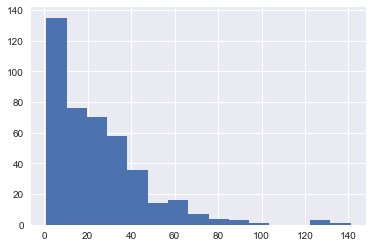

In [14]:
plt.hist(list(G.degree().values()), bins=15)

#### Топ10 по degree centrality

In [15]:
k_new = sorted(nx.degree(G).items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_new[i][0], k_new[i][1])

1.  Леша Загребин 141
2.  Амаль Имангулов 126
3.  Георгий Никитин 125
4.  Алексей Шадрин 124
5.  Miha Petrov 103
6.  Екатерина Сахарова 93
7.  Егор Завгородний 90
8.  Павел Данилов 85
9.  Вера Проваторова 82
10.  Аня Куприянова 82
11.  Марина Наговицына 82


# BETWENNESS CENTRALITY

In [16]:
bc = nx.betweenness_centrality(G)

#### Топ10 по betweenness centrality

In [17]:
k_bc = sorted(bc.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_bc[i][0], k_bc[i][1])

1.  Леша Загребин 0.08163548584325638
2.  Амаль Имангулов 0.07876352100647693
3.  Miha Petrov 0.07754571845803186
4.  Егор Завгородний 0.07728006781085234
5.  Алексей Шадрин 0.06841680551022343
6.  Георгий Никитин 0.05731699050606005
7.  Ксения Жилкина 0.05356563942745513
8.  Вика Шрамова 0.0389484041403894
9.  Екатерина Сахарова 0.036785856169597286
10.  Марина Наговицына 0.035997777103811
11.  Влад Стерхов 0.034824053237311706


(array([ 361.,   31.,   13.,    8.,    0.,    0.,    3.,    1.,    0.,
           1.,    1.,    0.,    1.,    0.,    4.]),
 array([ 0.        ,  0.00544237,  0.01088473,  0.0163271 ,  0.02176946,
         0.02721183,  0.03265419,  0.03809656,  0.04353893,  0.04898129,
         0.05442366,  0.05986602,  0.06530839,  0.07075075,  0.07619312,
         0.08163549]),
 <a list of 15 Patch objects>)

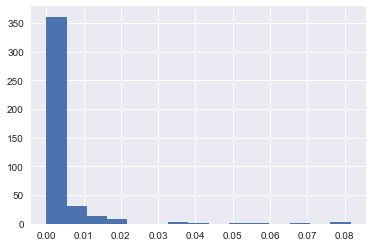

In [18]:
plt.hist(list(bc.values()), bins=15)

# CLOSENESS CENTRALITY

In [19]:
cc = nx.closeness_centrality(G)

#### Топ10 по closeness centrality

In [20]:
k_cc = sorted(cc.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_cc[i][0], k_cc[i][1])

1.  Леша Загребин 0.5472186287192755
2.  Амаль Имангулов 0.5465116279069767
3.  Алексей Шадрин 0.5388535031847134
4.  Miha Petrov 0.5388535031847134
5.  Егор Завгородний 0.5347661188369153
6.  Георгий Никитин 0.52875
7.  Екатерина Сахарова 0.5215782983970407
8.  Марина Наговицына 0.5029726516052319
9.  Павел Данилов 0.5011848341232228
10.  Даниил Шмырин 0.4901506373117034
11.  Степан Зимин 0.4873271889400922


(array([  2.,   1.,   4.,   2.,  18.,  13.,  39.,  51.,  82.,  86.,  74.,
         26.,  17.,   3.,   6.]),
 array([ 0.17559153,  0.20036667,  0.22514181,  0.24991695,  0.27469209,
         0.29946723,  0.32424237,  0.34901751,  0.37379265,  0.39856779,
         0.42334293,  0.44811807,  0.47289321,  0.49766835,  0.52244349,
         0.54721863]),
 <a list of 15 Patch objects>)

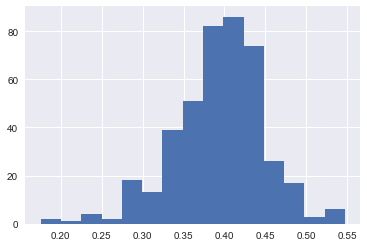

In [21]:
plt.hist(list(cc.values()), bins=15)

# PAGERANK

In [33]:
pr = nx.pagerank(G)

#### Топ10 по pagerank

In [34]:
k_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
for i in range(0,11):
    print(str(i+1)+". ", k_pr[i][0], k_pr[i][1])

1.  Леша Загребин 0.01122956047126623
2.  Амаль Имангулов 0.01101167429477217
3.  Георгий Никитин 0.010231330870541797
4.  Алексей Шадрин 0.01022657220665075
5.  Miha Petrov 0.0088234731044878
6.  Егор Завгородний 0.008581876367287408
7.  Екатерина Сахарова 0.007926876664506302
8.  Павел Данилов 0.006833099312628144
9.  Вера Проваторова 0.006733101996188511
10.  Марина Наговицына 0.006544021771516789
11.  Аня Куприянова 0.006490211991579692


(array([ 96.,  95.,  84.,  67.,  32.,  20.,  11.,   8.,   4.,   0.,   1.,
          2.,   0.,   2.,   2.]),
 array([ 0.00042622,  0.00114644,  0.00186667,  0.00258689,  0.00330711,
         0.00402733,  0.00474756,  0.00546778,  0.006188  ,  0.00690822,
         0.00762845,  0.00834867,  0.00906889,  0.00978912,  0.01050934,
         0.01122956]),
 <a list of 15 Patch objects>)

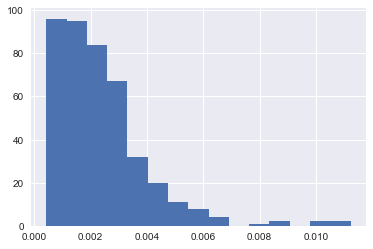

In [35]:
plt.hist(list(pr.values()), bins=15)

# DISTANCE SIMILARITIES

Тут короч матрица смежности, корреляции, Евклидово и косинусное расстояния

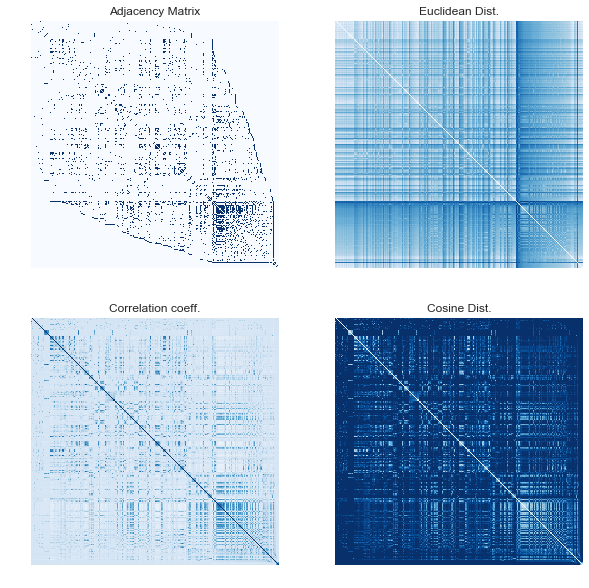

In [75]:
def plotDist(G):
    rcm = nx.utils.reverse_cuthill_mckee_ordering(G)
    A = nx.to_numpy_matrix(G, dtype=int, nodelist=list(rcm))
    A = np.asarray(A)
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Blues', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    ax[0, 0].axis('off')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    ax[1, 0].axis('off')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    ax[0, 1].axis('off')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Blues', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    ax[1, 1].axis('off')
    
plotDist(G)

# CLIQUES

Функция из лабы, которая работала вечность.

In [82]:
def FindKCliques(G, k):
    n = G.order()
    V = G.nodes()
    kCliques = []
    # Iterate over sizes
    for grSize in range(n, 1, -1):
        # Iterate over subgraphs
        for subV in itertools.combinations(V, grSize):
            # Not included in maximal and all distances are <= k
            if not any([set(subV).issubset(kcl) for kcl in kCliques]):
                if all([nx.shortest_path_length(G, pairs[0], pairs[1]) <= k for pairs in itertools.combinations(subV, 2)]):
                        kCliques.append(subV)
            
    return kCliques

Вместо нее использовал встроенную. Она мне понравилась больше.

На результате получаем cliques - это топовые клики

In [92]:
cliques = []
for i in nx.find_cliques(G):
    cliques.append((i, len(i)))
cliques = sorted(cliques, key=lambda tup: tup[1], reverse = True)

Взглянем на максимальный размер клик

In [101]:
[x[1] for x in cliques[:15]]

[20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]

Ага, двадцать. И их четыре штуки. Ради интереса глянем, кто там

In [105]:
for i in cliques[:4]:
    print(str(i[0]))

['Natasha Jess', 'Антон Крючков', 'Anna Lukutina', 'Ольга Старчикова', 'Тамара Шангина', 'Марина Атоянц', 'Степан Зимин', 'Артем Суевалов', 'Камилла Сафиуллина', 'Ксения Титова', 'Вера Проваторова', 'Павел Данилов', 'Рома Кизилов', 'Олег Конопля', 'Роман Бобров', 'Александр Пивненко', 'Оля Ломакина', 'Екатерина Сахарова', 'Карен Валитов', 'Егор Бурков']
['Natasha Jess', 'Антон Крючков', 'Anna Lukutina', 'Ольга Старчикова', 'Тамара Шангина', 'Марина Атоянц', 'Степан Зимин', 'Артем Суевалов', 'Камилла Сафиуллина', 'Ксения Титова', 'Вера Проваторова', 'Павел Данилов', 'Рома Кизилов', 'Олег Конопля', 'Роман Бобров', 'Александр Пивненко', 'Оля Ломакина', 'Екатерина Сахарова', 'Карен Валитов', 'Амаль Имангулов']
['Natasha Jess', 'Антон Крючков', 'Anna Lukutina', 'Ольга Старчикова', 'Тамара Шангина', 'Марина Атоянц', 'Степан Зимин', 'Артем Суевалов', 'Камилла Сафиуллина', 'Ксения Титова', 'Роберт Хачатрян', 'Роман Бобров', 'Оля Ломакина', 'Павел Данилов', 'Александр Пивненко', 'Рома Кизилов',

Ну а здесь смотрим, какие люди попали в эти максимальные клики сколько раз

In [109]:
names_in_top_clique = [item for sublist in [x[0] for x in cliques[:4]] for item in sublist]

In [112]:
d = {}
for name in names_in_top_clique:
    d[name] = names_in_top_clique.count(name)
sorted(d.items(), key=operator.itemgetter(1), reverse=True)

[('Natasha Jess', 4),
 ('Антон Крючков', 4),
 ('Anna Lukutina', 4),
 ('Ольга Старчикова', 4),
 ('Тамара Шангина', 4),
 ('Марина Атоянц', 4),
 ('Степан Зимин', 4),
 ('Артем Суевалов', 4),
 ('Камилла Сафиуллина', 4),
 ('Ксения Титова', 4),
 ('Павел Данилов', 4),
 ('Рома Кизилов', 4),
 ('Олег Конопля', 4),
 ('Роман Бобров', 4),
 ('Александр Пивненко', 4),
 ('Оля Ломакина', 4),
 ('Екатерина Сахарова', 4),
 ('Карен Валитов', 4),
 ('Вера Проваторова', 2),
 ('Егор Бурков', 2),
 ('Амаль Имангулов', 2),
 ('Роберт Хачатрян', 2)]

Какая неожиданность, везде одни и те же. Справедливости ради, все ребята с моего курса ФКН (кроме Александра Пивненко), так что это в какой-то степени отображает коммьюнити

Ну а тут просто построим гистрограммку по кликам

(array([  99.,  142.,  210.,  223.,  277.,  334.,  415.,  448.,  327.,
         340.,  385.,  230.,  237.,  184.,  226.,  102.,   38.,   16.]),
 array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <a list of 18 Patch objects>)

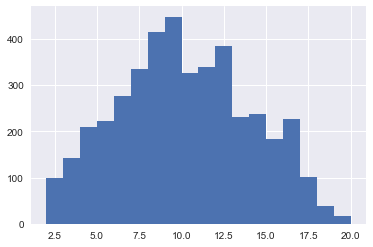

In [117]:
plt.hist([x[1] for x in cliques], bins=18)

# k-core

Здесь я запускал специальную функцию для поиска k-core, импортировал в файл, оттуда в Gephi. Напомню, там красивее.

In [139]:
d = nx.core_number(G)
cocore = pd.Series(d)

In [153]:
cocore

Anastasiia Vasiullina    23
Andrei Logvinenko        22
Anna Lukutina            24
Anna Melnikova           23
Anna Rakovskaya          11
Beatrix Sharp            16
Christopher Side          4
Dasha Osipova            23
Dmitriy Dyachenko        23
Dmitry Doroshko           8
Dr Inking                 4
Ilona Papava             20
Kirill Yatsushko         11
Maria Belousova          23
Math Help                 1
Miha Petrov              23
Natasha Jess             24
Olya Solodskaya          13
Polina Srebnitskaya       3
Primat Активный          23
Roct Bb                  24
Rudolf Schenker          17
Sonya Cheshirskaya        8
Valeriya Shramova         3
Vladimir Arkashev        23
Айбек Аланов             20
Александр Александров    10
Александр Вотяков        23
Александр Долгошеев       5
Александр Ермишкин       17
                         ..
Тамерлан Таболов          8
Таня Григорович           4
Таня Лопатюк             17
Татьяна Лукьянова         2
Татьяна Трегубова   

In [152]:
cocore.to_csv("filename.csv")

# RANDOM GENERATION

На каждую вероятность генерим по несколько графов и берем среднее значение

In [170]:
n = len(G.nodes())
stats = []
iter = 10
for p in np.linspace(0.1, 0.9, 9):
    print("start iteration with p =", p, end='')
    cur_p_stats = []
    for i in range(iter):
        nG = nx.erdos_renyi_graph(n=n, p=p)
        ndiameter = nx.diameter(nG.subgraph(max(nx.connected_component_subgraphs(nG), key=len)))
        nclust_coef = nx.average_clustering(nG)
        navg_short_path = nx.average_shortest_path_length(nG)
        cur_p_stats.append([ndiameter, nclust_coef, navg_short_path])
        print("|", end='')
    print()
    stats.append((p, np.mean(cur_p_stats, axis=0)))
for stat in stats:
    print(stat[1], stat[0])
print([diameter, clust_coef, avg_short_path])

start iteration with p = 0.1||||||||||
start iteration with p = 0.2||||||||||
start iteration with p = 0.3||||||||||
start iteration with p = 0.4||||||||||
start iteration with p = 0.5||||||||||
start iteration with p = 0.6||||||||||
start iteration with p = 0.7||||||||||
start iteration with p = 0.8||||||||||
start iteration with p = 0.9||||||||||
[ 3.          0.09994832  1.91288862] 0.1
[ 2.          0.20014851  1.79995986] 0.2
[ 2.          0.30013017  1.70003903] 0.3
[ 2.          0.39996725  1.60008252] 0.4
[ 2.          0.49993215  1.50010594] 0.5
[ 2.          0.59955152  1.40040033] 0.6
[ 2.          0.69995423  1.30002119] 0.7
[ 2.          0.80014077  1.19985615] 0.8
[ 2.          0.90014639  1.09986618] 0.9
[7, 0.508731394000387, 2.5941723538070387]


In [166]:
a = [[1, 2], [3,4]]
np.mean(a, axis=0)

array([ 2.,  3.])